# wrapping a single zarr as a yt pyramid

This notebook takes a base zarr array (on-disk, chunked) and wraps it in yt grids at decreasing resolution levels. Data for each level is evaluated using the callable functionality for `load_amr_grids` -- the value at a given pixel and level is calculated as the mean of all the pixels at the highest resolution level. 

## create a base image

In [1]:
import numpy as np 
import yt 
import zarr

# define the highest resolution grid 
highest_res = np.array((256,256,256), dtype=int)
grid_dims = np.array((64,64,64), dtype=int)

# virtual pyramid settings
refine_factor = np.array((2,2,2), dtype=int)

# spatial extent of the whole domain
domain_le = np.array([0., 0., 0.])
domain_re = np.array([1., 1., 1.])

In [2]:
zg = zarr.group('./zarr-test-image.zarr', overwrite=True)

In [3]:
for field in ('field1', 'field2'):    
    zg.array(field, np.random.random(highest_res), chunks=tuple(grid_dims))

In [4]:
fld3 = np.zeros(highest_res)
fld3[highest_res[0]//3:,highest_res[1]//3:,highest_res[2]//3:] = 1.0 
zg.array('field3', fld3, chunks=tuple(grid_dims))

<zarr.core.Array '/field3' (256, 256, 256) float64>

In [5]:
flds = list(zg.array_keys())
flds

['field1', 'field2', 'field3']

## Grid settings and generation for `load_amr_grids`

In [25]:
#calculate max level : coarsen until we get 1 grid across domain. 
max_allowed=100
current_level_dims = highest_res 
current_grid_dims = grid_dims


# brain not working, should be able calculate this directly... just looping
for i_level in range(max_allowed):
    n_grids_i = current_level_dims / grid_dims
    print(n_grids_i)
    if np.any( n_grids_i< 1): 
        print("cannot coarsen further")
        max_level = i_level - 1 # yt levels are 0-indexed
        break 
    current_level_dims = current_level_dims // refine_factor    

max_level

[4. 4. 4.]
[2. 2. 2.]
[1. 1. 1.]
[0.5 0.5 0.5]
cannot coarsen further


2

In [26]:
def _single_level_grids(level, level_dims, grid_dims):
    # for a single grid level, get all the grid extents 
    #
    # level : the current level number
    # level_dims : the resolution of the entire level 
    # grid_dims : the resoulton of a single grid (i.e., one chunk)
    #
    # returns a list of grid dictionaries 

    n_grids_by_dim = level_dims // grid_dims  # number of grids in each dim 
    n_grids = int(np.prod(n_grids_by_dim)) # total grids at this level 
    
    # spatial extent of a grid in each dim :
    grid_ds = (domain_re - domain_le) / n_grids_by_dim 
    
    grids = [] 
    for i_grid in range(n_grids):
        ijk_grid = np.unravel_index(i_grid, n_grids_by_dim, order='C')
        # lei = ijk_grid * grid_dims  # global start index at this level
        # rei = lei + grid_dims       # global stop index at this level
        le = domain_le + ijk_grid * grid_ds 
        re = le + grid_ds
        grid_dict = {'left_edge': le, 
                     'right_edge': re, 
                     'dimensions': grid_dims, 
                     'level': level, 
                     }                     
        grids.append(grid_dict)
    return grids

Finally, loop over levels, decreasing the active resolution at each level

In [27]:
grids = [] 

current_level_dims = highest_res 

for i_lev in range(max_level, -1,-1):    
    print(current_level_dims)        
    grids_i = _single_level_grids(i_lev, current_level_dims, grid_dims)
    grids.extend(grids_i)    
    current_level_dims = current_level_dims // refine_factor    

[256 256 256]
[128 128 128]
[64 64 64]


In [28]:
# probably not really needed. WAIT IT IS NEEDED! i guess grids must be supplied in a specific order?
grids.reverse()  

## the callable 

this is where grid data will actually get read in. If the active `grid` is at the max resolution, it just reads directly. Otherwise, it will average all of the high resolution pixels contained by each coarse pixel. 

In [29]:
def read_from_zarr(grid, field_tuple):
    field = field_tuple[1]
    si = grid.get_global_startindex()
    ei = si + grid.ActiveDimensions
    level = grid.Level # level 0 low res
    max_level = grid.index.max_level
    pyramid_level = max_level - level
    
    if pyramid_level == 0: 
        # just read direct from zarr
        vals = zg[field][si[0]:ei[0], 
                         si[1]:ei[1], 
                         si[2]:ei[2]]
        return vals     

    # level > 0: average all the covered pixels 
    
    # starting indices at current level 
    xyz_i = [np.arange(si[idim], ei[idim]) for idim in range(3)]
    
    # starting indices at level 0
    xyz_i_lev0 = [xyz_i[idim] * refine_factor[idim]**(pyramid_level-0) for idim in range(3)]
    
    # starting level 0 index permuations 
    xi0, yi0, zi0 = np.meshgrid(*xyz_i_lev0, indexing='ij')
    xi1d = xi0.ravel()
    yi1d = yi0.ravel()
    zi1d = zi0.ravel()                        
    
    # number of level 0 pixels covered by one pixel at current level
    lev0_Npixels = refine_factor**(pyramid_level-0)
    # print(level, lev0_Npixels, si, ei)
    
    # find average of covered level 0 pixels -- this is a bottleneck
    im0 = np.zeros(xi1d.shape)
    N_pixels = 0
    for offset_x in range(0, lev0_Npixels[0]):
        for offset_y in range(0, lev0_Npixels[1]):
            for offset_z in range(0, lev0_Npixels[2]):
                # print(offset_x, offset_y, offset_z)
                im0 += zg[field][xi1d+offset_x, yi1d+offset_y, zi1d+offset_z]
                N_pixels += 1
    
    im0 /= N_pixels
    im0 = im0.reshape(ei - si)

    return im0        

In [30]:
class MockIndex:
    def __init__(self, max_level):
        self.max_level = max_level
        
class MockGrid:
    def __init__(self, si, ei, level, max_level):
        self.si = np.asarray(si).astype(int)
        self.ei = np.asarray(ei).astype(int)
        self.Level = level
        self.ActiveDimensions = self.ei - self.si
        self.index = MockIndex(max_level)
        
    def get_global_startindex(self):
        return self.si


In [31]:
g = MockGrid((16,16,16), (32,32,32), 1, 2)
read_from_zarr(g, ('stream', 'field1')).shape

(16, 16, 16)

In [32]:
for g in grids:    
    for field in zg.array_keys():
        g[field] = (read_from_zarr, "")
        

## actually load the data

In [33]:
ds = yt.load_amr_grids(grids, grid_dims)

yt : [INFO     ] 2024-09-11 10:27:18,051 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-09-11 10:27:18,052 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-09-11 10:27:18,052 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-09-11 10:27:18,053 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-09-11 10:27:18,053 Parameters: cosmological_simulation   = 0


In [34]:
ds.field_list

[('stream', 'field1'), ('stream', 'field2'), ('stream', 'field3')]

yt : [INFO     ] 2024-09-11 10:27:23,102 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-11 10:27:23,103 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-11 10:27:23,104 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-11 10:27:23,104 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-11 10:27:23,105 Making a fixed resolution buffer of (('stream', 'field1')) 800 by 800



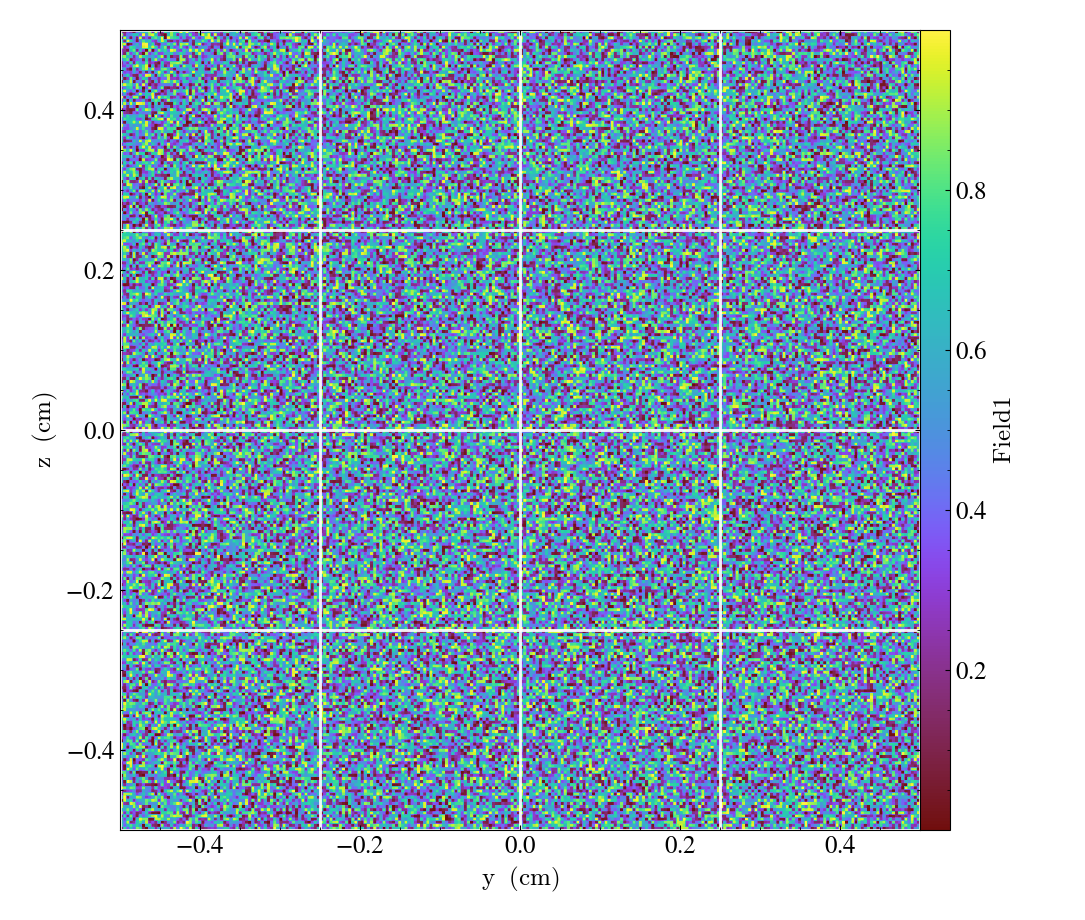

In [35]:
slc = yt.SlicePlot(ds, 'x', ('stream', 'field1'))
slc.set_log(('stream', 'field1'), False)
slc.annotate_grids(edgecolors=(1,1,1),linewidth=2)

Check the smoothing

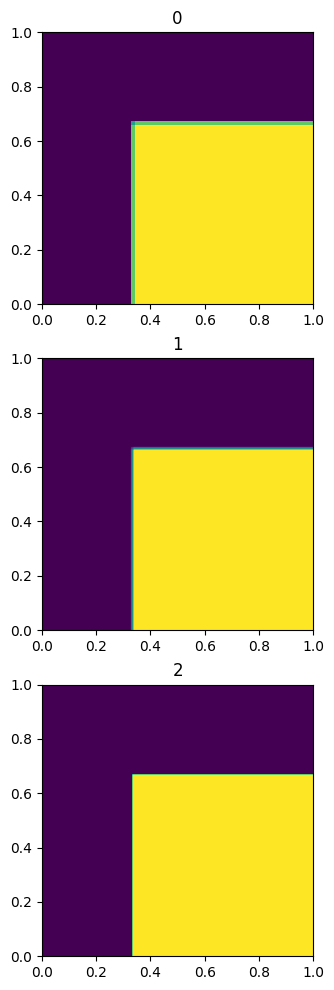

In [36]:
import matplotlib.pyplot as plt

f,axs = plt.subplots(nrows=ds.max_level+1,ncols=1, figsize=(4,12))

for level in range(ds.max_level+1):
    dom_dims = ds.domain_dimensions * (ds.refine_by**level)
    cg = ds.covering_grid(level, ds.domain_left_edge, dom_dims)
    data = cg['stream', 'field3']
    zdim = data.shape[-1] // 2
    axs[level].imshow(data[:,:,zdim], extent=(0,1,0,1))
    axs[level].set_title(level)